In [2]:
!pip install datasets

# Cases Similarity DS Task

## The Task
* Part #1 - Given 2 cases ids - find a similarity score [0-1] that measures how similar the cases are
* Part #2 - Build a multiclass classification model to predict domain for each case

## Data
* Dataframe with 3 columns containing past legal cases
  * id - unique id of the case
  * text - the actual text of the case
  * domain - a categorical value representing the domain which this case belongs to

In [3]:
import pandas as pd
import numpy as np

# Reading the Legal Cases Dataframe
* case_id - represents a unique id for each case
* text - represents the complaint text for each case
* domain - the domain name of which this case belongs to

In [4]:
from datasets import load_dataset
dataset = load_dataset('darrow-ai/legal-task')
dataset = dataset['train'].to_pandas()
dataset.head()

id                                               text  \
0  r-e4EYcBD5gMZwcz41zP  UNITED STATES DISTRICT COURT \nEASTERN DISTRIC...   
1  i9H5DocBD5gMZwcztj0y  IN THE UNITED STATES DISTRICT COURT \nFOR THE ...   
2  SMn3DYcBD5gMZwcz-hwH  IN THE UNITED STATES DISTRICT COURT\n FOR THE ...   
3  GMIWDYcBD5gMZwczDQBb  Case No. _______________ \n \n \nCLASS ACTION ...   
4  lELw_IgBF5pVm5zYONwC  UNITED STATES DISTRICT COURT \n SOUTHERN DISTR...   

                   domain  
0          consumer fraud  
1                 privacy  
2                 privacy  
3  criminal & enforcement  
4          consumer fraud

# Start Implement From Here

### Data Preprocessing

#### Know your data:
- Inconsistencies or errors in the data
- Basic statistics

In [7]:
total_cases = len(dataset)
print(f"Total cases: {total_cases}")

Total cases: 1202


#####Null checks

In [8]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Check for missing values
print("Missing values in each column:")
print(dataset.isnull().sum())

Missing values in each column:
id              0
text            0
domain          0
text_cleaned    0
dtype: int64


#####Duplicates

In [9]:
# Check for duplicate rows
print(f"Number of duplicate rows in the dataset: {dataset.duplicated().sum()}")

# Check for duplicate text entries (even if case_id is different)
print(f"Number of duplicate text entries: {dataset['text'].duplicated().sum()}")

# Check for duplicate case_id entries
print(f"Number of duplicate case_id entries: {dataset['id'].duplicated().sum()}")

Number of duplicate rows in the dataset: 0
Number of duplicate text entries: 0
Number of duplicate case_id entries: 0


In [10]:
# Find and display the rows where the text is duplicated
duplicate_text_rows = dataset[dataset.duplicated(subset=['text'], keep=False)]

# Display the duplicate rows
print("Duplicate text entries:")
display(duplicate_text_rows)


Duplicate text entries:


Empty DataFrame
Columns: [id, text, domain, text_cleaned]
Index: []

##### Domain labels

In [11]:
# Unique domain labels before cleaning
print("Unique domain labels before cleaning:")
print(dataset['domain'].unique())

# Checking for label inconsistencies (e.g., case-sensitivity issues in domain names)
# Convert domain labels to lowercase and strip whitespaces for consistency check
dataset['domain_clean'] = dataset['domain'].str.lower().str.strip()

# Unique domain labels after cleaning
print("Unique domain labels after cleaning:")
print(dataset['domain_clean'].unique())

Unique domain labels before cleaning:
['consumer fraud' 'privacy' 'criminal & enforcement' 'securities'
 'civil rights, immigration, family' 'antitrust' 'employment & labor'
 'discrimination' 'intellectual property & communication' 'healthcare'
 'products liability and mass tort' 'environmental & natural resources']
Unique domain labels after cleaning:
['consumer fraud' 'privacy' 'criminal & enforcement' 'securities'
 'civil rights, immigration, family' 'antitrust' 'employment & labor'
 'discrimination' 'intellectual property & communication' 'healthcare'
 'products liability and mass tort' 'environmental & natural resources']


##### Text check (content, length,words)

In [12]:
# Inconsistent characters in the text (checking for non-ASCII characters)
def check_non_ascii(text):
    return bool(re.search(r'[^\x00-\x7F]+', text))


# Check for any non-ASCII text
dataset['non_ascii'] = dataset['text'].apply(check_non_ascii)
non_ascii_cases = dataset[dataset['non_ascii'] == True]
print(f"Number of cases with non-ASCII characters: {len(non_ascii_cases)}")

if len(non_ascii_cases) > 0:
    print("Examples of texts with non-ASCII characters:")
    display(non_ascii_cases[['id', 'text']].head())


Number of cases with non-ASCII characters: 1187
Examples of texts with non-ASCII characters:


id                                               text
0  r-e4EYcBD5gMZwcz41zP  UNITED STATES DISTRICT COURT \nEASTERN DISTRIC...
1  i9H5DocBD5gMZwcztj0y  IN THE UNITED STATES DISTRICT COURT \nFOR THE ...
2  SMn3DYcBD5gMZwcz-hwH  IN THE UNITED STATES DISTRICT COURT\n FOR THE ...
3  GMIWDYcBD5gMZwczDQBb  Case No. _______________ \n \n \nCLASS ACTION ...
4  lELw_IgBF5pVm5zYONwC  UNITED STATES DISTRICT COURT \n SOUTHERN DISTR...

In [13]:
# Basic text processing - Word count for each case
dataset['word_count'] = dataset['text'].apply(lambda x: len(x.split()))

# Descriptive statistics for word count
print("Descriptive statistics for word count:")
print(dataset['word_count'].describe())

# Descriptive statistics for text length (number of characters per case)
dataset['text_length'] = dataset['text'].apply(len)

print("Descriptive statistics for text length:")
print(dataset['text_length'].describe())

Descriptive statistics for word count:
count     1202.000000
mean      6211.322795
std       6102.249249
min        139.000000
25%       2639.500000
50%       4681.500000
75%       7409.000000
max      66981.000000
Name: word_count, dtype: float64
Descriptive statistics for text length:
count      1202.000000
mean      41836.473378
std       41629.935396
min        1035.000000
25%       17420.000000
50%       31160.000000
75%       50390.250000
max      441073.000000
Name: text_length, dtype: float64


#### Visulisations

Check the distribution of domain labels -  Imbalance

<ipython-input-23-ac1685d4f82f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts.index, y=domain_counts.values, palette='viridis')


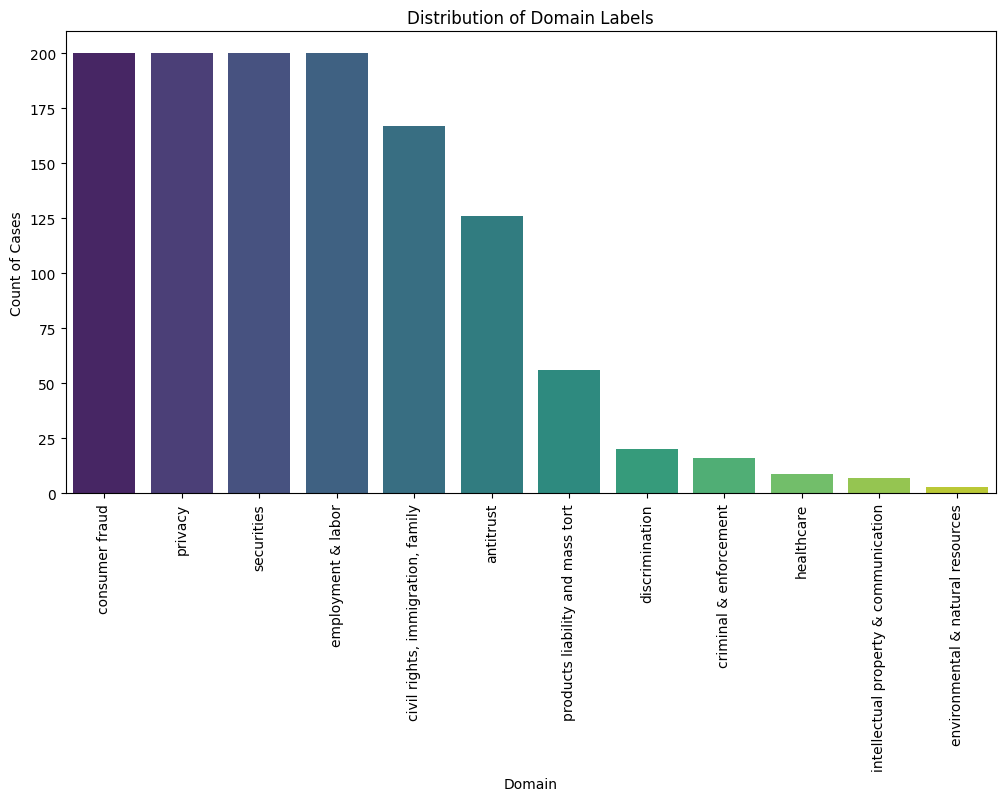

In [23]:
domain_counts = dataset['domain'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=domain_counts.index, y=domain_counts.values, palette='viridis')
plt.title('Distribution of Domain Labels')
plt.xlabel('Domain')
plt.ylabel('Count of Cases')
plt.xticks(rotation=90)
plt.show()

Distribution of text length


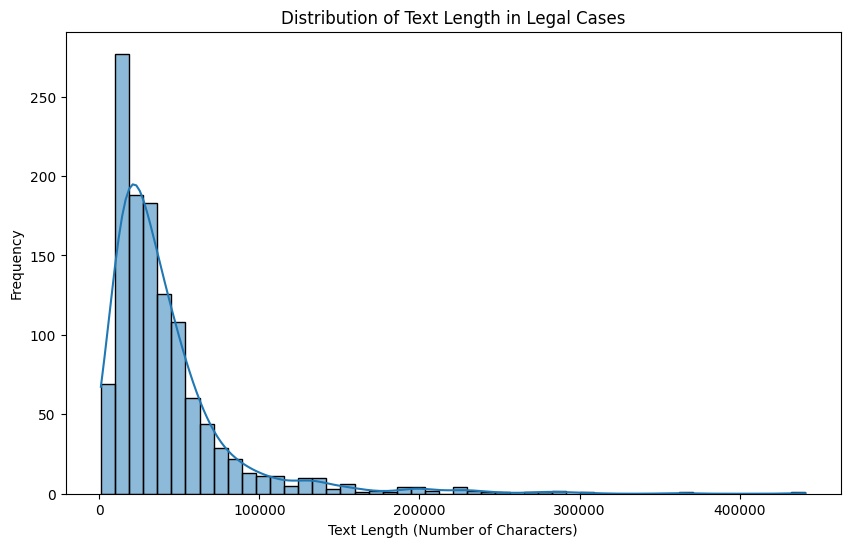

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(dataset['text_length'], kde=True, bins=50)
plt.title('Distribution of Text Length in Legal Cases')
plt.xlabel('Text Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

Distribution of word count

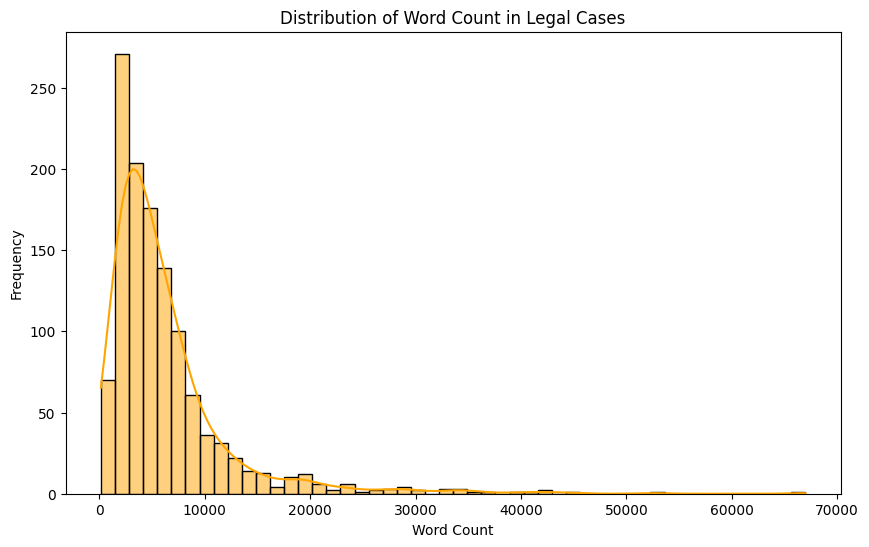

In [26]:
# Distribution of word count
plt.figure(figsize=(10, 6))
sns.histplot(dataset['word_count'], kde=True, bins=50, color='orange')
plt.title('Distribution of Word Count in Legal Cases')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

##### Domain specific word cloud

Domain: consumer fraud


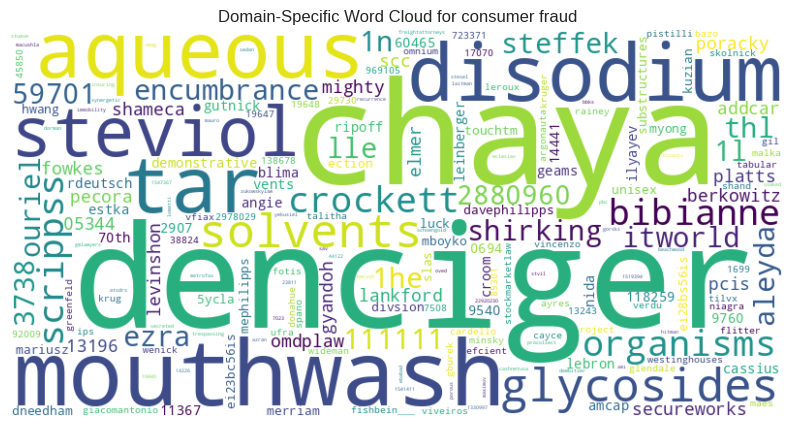

Domain: privacy


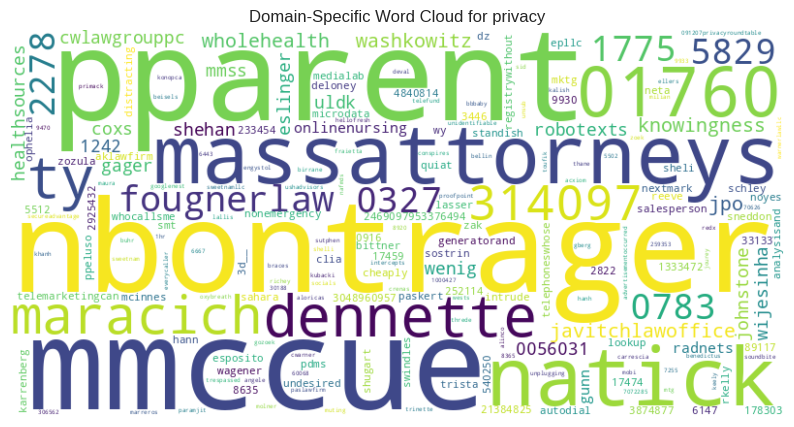

Domain: criminal & enforcement


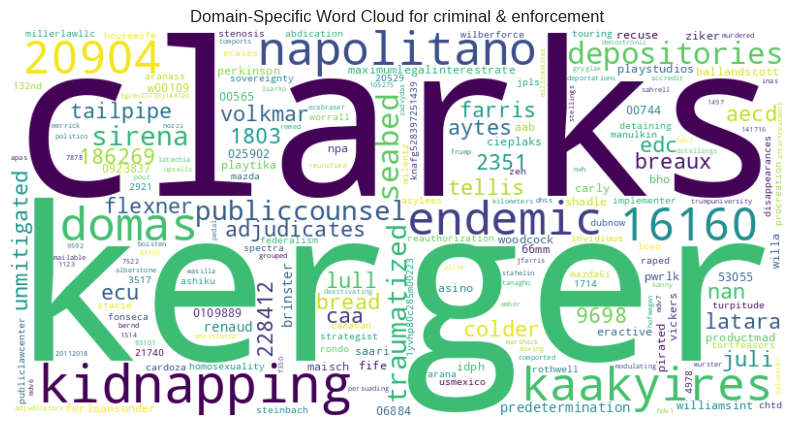

Domain: securities


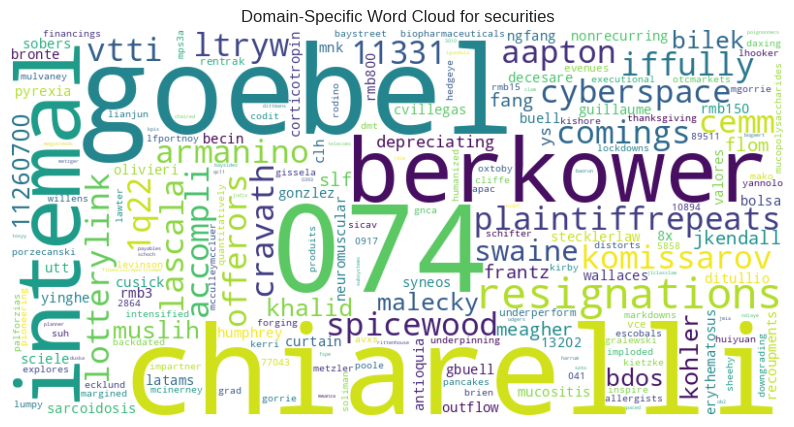

Domain: civil rights, immigration, family


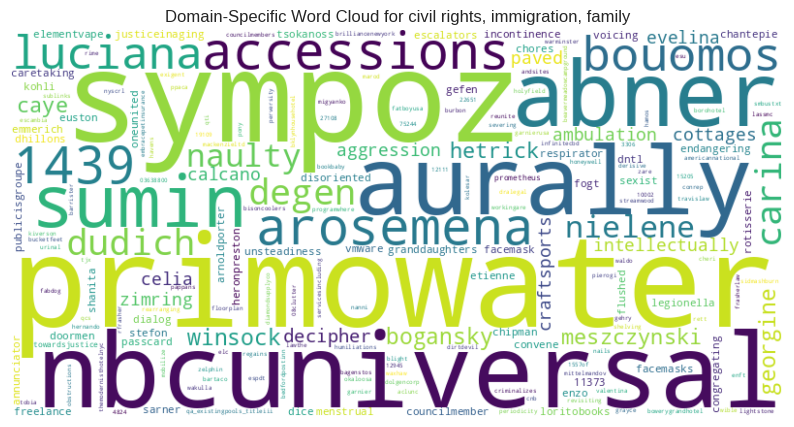

Domain: antitrust


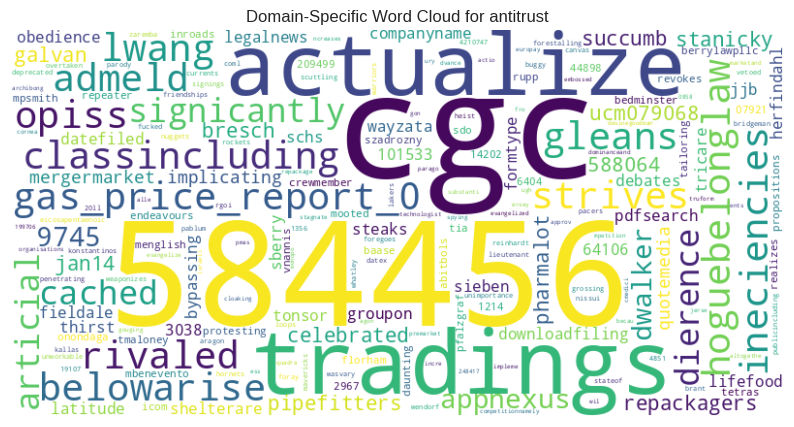

Domain: employment & labor


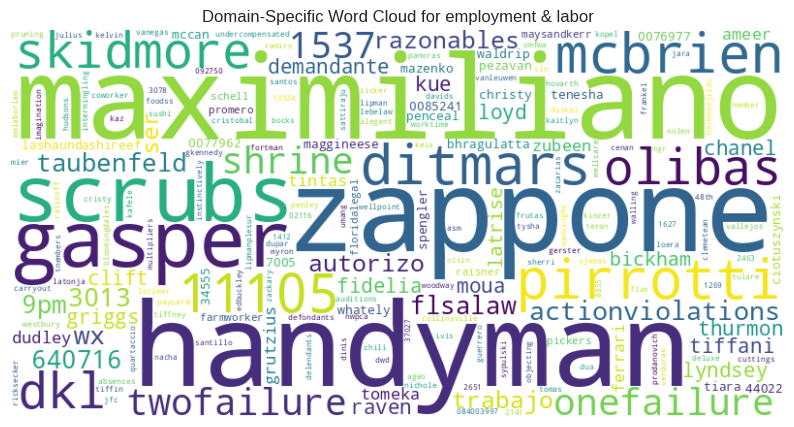

Domain: discrimination


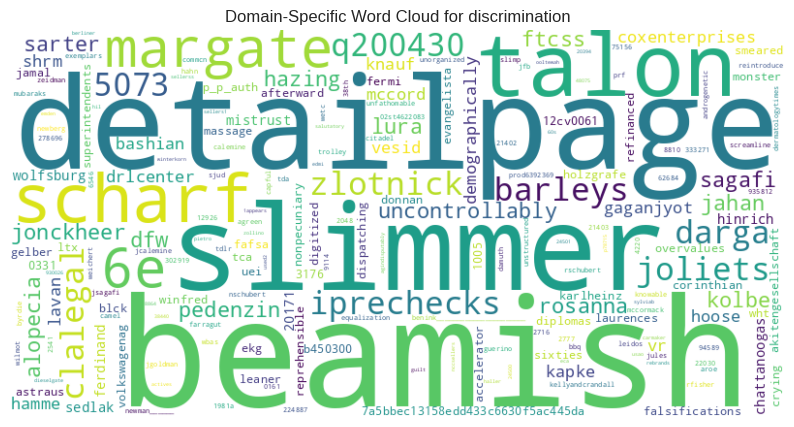

Domain: intellectual property & communication


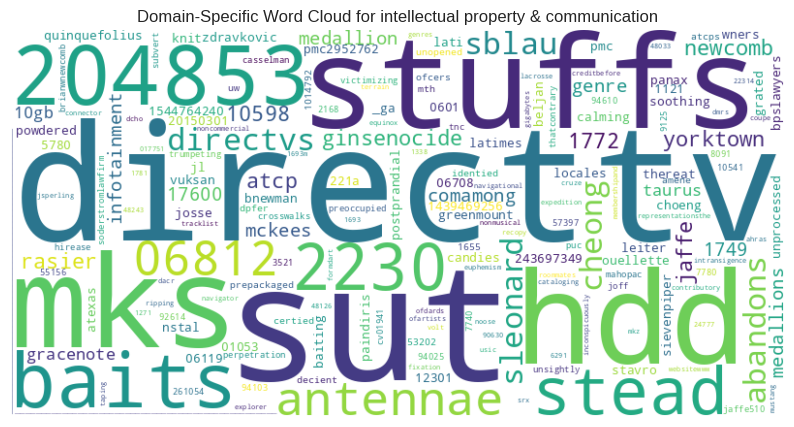

Domain: healthcare


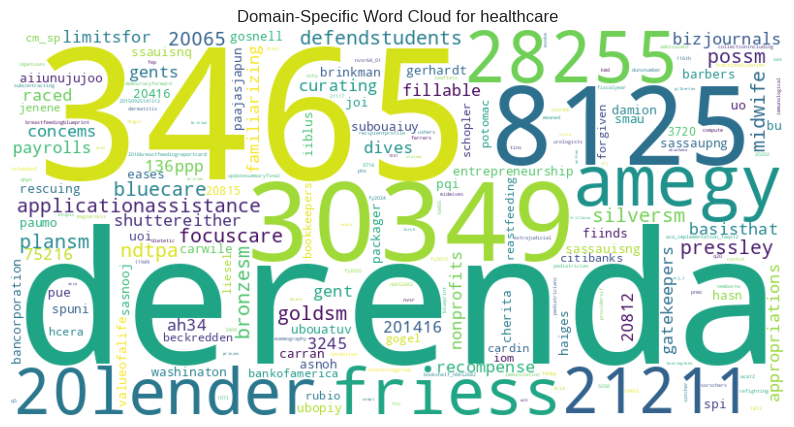

Domain: products liability and mass tort


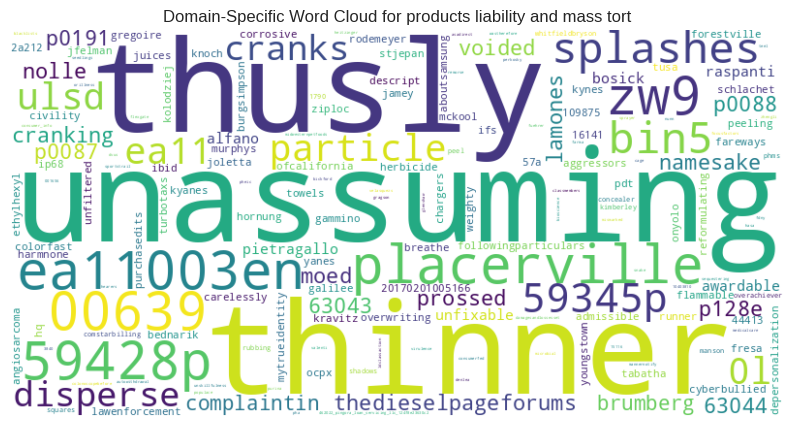

Domain: environmental & natural resources


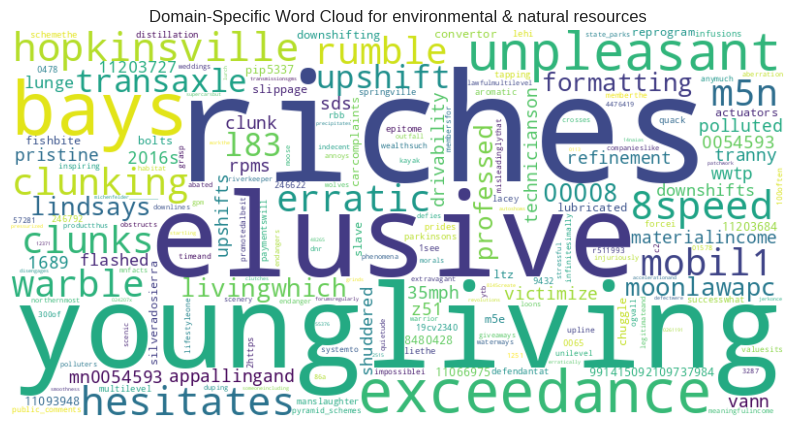

In [15]:
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# 1. Tokenization function (lowercase, remove non-alphabetic, etc.)
def tokenize(text):
    words = re.findall(r'\b\w+\b', text.lower())  # Find all words (ignore punctuation)
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]  # Remove stop words
    return words

# 2. Create a global word frequency dictionary (all domains combined)
all_text = ' '.join(dataset['text_cleaned'])
all_words = tokenize(all_text)
global_word_counts = Counter(all_words)
# 3. Create a domain-specific word list and filter out common words
def domain_specific_words(domain):
    # Get all the text for the specific domain
    domain_text = ' '.join(dataset[dataset['domain_clean'] == domain]['text_cleaned'])

    # Tokenize and count word frequencies for this domain
    domain_words = tokenize(domain_text)
    domain_word_counts = Counter(domain_words)

    # Remove common words that appear frequently across all domains
    domain_specific = {word: count for word, count in domain_word_counts.items() if global_word_counts[word] <= 3}

    return domain_specific

# 4. Generate a domain-specific word cloud excluding common words
for domain in dataset['domain_clean'].unique():
    print(f"Domain: {domain}")
    # Get the domain-specific words
    domain_word_dict = domain_specific_words(domain)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(domain_word_dict)

    # Display the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Domain-Specific Word Cloud for {domain}')
    plt.show()


#### Preprocessing

**Internediate Insights**
- We see there are duplicate texts that we will need to handle
- Text normalization is needed for cases with non-ASCII characters
- Text length and word count varies a lot - potentially incomplete case
- Domain labels are imbalance


In [16]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define custom stopwords for legal documents
legal_stopwords = list(stopwords.words('english') + ['plaintiff', 'defendant', 'court', 'case', 'law', 'legal', 'judge', 'action', "plaintiff", "defendant", "court", "judge", "case", "law",
    "legal", "complaint", "class action", "civil action", "trial", "jurisdiction", "venue", "damages", "relief", "allegations", "action", "parties", "violations", "cause of action", "u.s.c.",
    "usc", "rule", "procedure", "federal",
    "state", "attorneys", "injunctive relief", "motion", "filed",
    "hereinafter", "claims", "violated", "court's decision", "statutory",
    "jurisdiction and venue", "class members", "complaint filed", "motion filed",
    "exhibit", "attached", "certified", "filed on", "case number", "counsel",
    "representation", "retained", "discovery", "deposition", "affidavit",
    "testimony", "evidence", "trial court", "appeal", "settlement",
    "stipulation", "introduction", "preliminary statement", "facts",
    "nature of action", "count i", "count ii", "count iii",
    "section headers", "legal citations", "dates and addresses",
    "paragraph numbers", "signature lines", "respectfully submitted",
    "exhibits", "on behalf of", "consent", "dated", "designation of trial location",
    "demand for jury trial", "tcpa", "fdcpa", "debt collector",
    "recovery services", "telephone number", "cellular phone",
    "credit card payment", "collection letter"])


### Step 1: Text Preprocessing ###
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower().strip()

    # Remove non-alphabetic characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Tokenize (split) into words and remove short words
    words = text.split()
    words = [word for word in words if len(word) > 2 and word not in legal_stopwords]  # Remove short words and stopwords

    return ' '.join(words)

# 1. Remove duplicate text entries
dataset = dataset.drop_duplicates(subset=['text'], keep='first')

# 2. Text Cleaning
dataset['text_cleaned'] = dataset['text'].apply(lambda x: preprocess_text(x))


# 4. Remove words that appear too frequently (e.g., words that appear more than 100 times globally)
def remove_frequent_words(text, global_word_counts, threshold=100):
    words = text.split()
    words = [word for word in words if global_word_counts[word] <= threshold]
    return ' '.join(words)

dataset['text_cleaned_no_generic_words'] = dataset['text_cleaned'].apply(lambda x: remove_frequent_words(x, global_word_counts, threshold=100))

# 5. Remove Incomplete Cases (e.g., cases with very low word count)
dataset['word_count'] = dataset['text_cleaned_no_generic_words'].apply(lambda x: len(x.split()))
dataset = dataset[dataset['word_count'] > 200]



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
dataset['text_cleaned_no_generic_words'][0]

'chaya denciger, others situated, no: 1:19-cv-4581 ____________ plaintiff, -v.- first incorporated, 1-25. defendant(s) chaya denciger (hereinafter, plaintiff), resident, attorneys, first (hereinafter defendant), others situated, procedure, upon counsel, except plaintiff, upon plaintiff\'s knowledge. introduction/preliminary (hereinafter fdcpa) 1977 "abundant abusive, deceptive, many collectors." 1692(a). time, "abusive bankruptcies, instability, jobs, invasions privacy." id. "existing laws[we]re consumers," "\'the debts" "misrepresentation practices." 1692(b) (c). practices, also "insure competitively disadvantaged." id. 1692(e). l692(b), act. id. 1692k. et. seq. pendent 1367(a). 1391(b)(2) well part occurred. seq. code, fdcpa, relief. york, kings, 1336 58th st. apt. brooklyn, 11219-4564. "debt collector" 1692(a)(6) york. c/o corporation, st., york, ny, 10005. upon belief, mail, telephone, due another. 10. l-25, substituting whose made action. 11. case, fed. civ. 23(a) 23(b)(3). 12. of

### Part #1 - Similarity Calculation

In [23]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

def create_tfidf_matrix(dataset):
    # Create a TF-IDF vectorizer with custom parameters
    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,  # Limit to top 5000 features
        ngram_range=(1, 2),  # Use both unigrams and bigrams
        stop_words=legal_stopwords
    )
    # Fit and transform the processed text
    tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['text_cleaned_no_generic_words'])
    return tfidf_matrix, tfidf_vectorizer

tfidf_matrix, tfidf_vectorizer = create_tfidf_matrix(dataset)

### Step 5: Similarity Calculation ###
def calculate_cases_similarity(case_id_a, case_id_b):
    '''
    This method returns a similarity score [0-1] that represents how similar the legal cases are.

    It compares the text (using sections or full text), key phrases (dates, monetary values, citations),
    and checks if the domains are the same.

    @param case_id_a - the id of the first case
    @param case_id_b - the id of the second case
    @returns a similarity score between the cases
    @rtype float
    '''

    # Get the indices of the cases
    idx_a = dataset.index[dataset['id'] == case_id_a].tolist()[0]
    idx_b = dataset.index[dataset['id'] == case_id_b].tolist()[0]

    # Get the text for the cases
    text_a = dataset.loc[idx_a, 'text_cleaned_no_generic_words']
    text_b = dataset.loc[idx_b, 'text_cleaned_no_generic_words']


    # Calculate text similarity using TF-IDF
    text_similarity = cosine_similarity(tfidf_vectorizer.transform([text_a]), tfidf_vectorizer.transform([text_b]))[0][0]

    # Check if the domains are the same
    domain_match = 1 if dataset.loc[idx_a, 'domain'] == dataset.loc[idx_b, 'domain'] else 0

    # Combine all similarity measures
    combined_similarity = (
        0.8 * text_similarity +      # Text similarity (highest weight)
        0.2 * domain_match        # Domain match

    )

    return combined_similarity


In [24]:
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
# Sample two cases from the same domain and two cases from different domains
same_domain = dataset[dataset['domain_clean'] == 'consumer fraud'].sample(2)['id'].values
diff_domain = [dataset[dataset['domain_clean'] == 'consumer fraud'].sample(1)['id'].values[0],
               dataset[dataset['domain_clean'] == 'antitrust'].sample(1)['id'].values[0]]

# Test similarity for cases from the same domain
similarity_same = calculate_cases_similarity(same_domain[0], same_domain[1])

# Test similarity for cases from different domains
similarity_diff = calculate_cases_similarity(diff_domain[0], diff_domain[1])

print(f"Similarity between two cases from the same domain: {similarity_same:.4f}")
print(f"Similarity between two cases from different domains: {similarity_diff:.4f}")

Similarity between two cases from the same domain: 0.3853
Similarity between two cases from different domains: 0.0490


### Part #2 - Multiclass Classification Model

In [78]:
# prompt: domain counts

domain_counts = dataset['domain'].value_counts()
print(domain_counts)


domain
consumer fraud                           200
securities                               200
privacy                                  199
employment & labor                       198
civil rights, immigration, family        166
antitrust                                125
products liability and mass tort          55
discrimination                            20
criminal & enforcement                    16
healthcare                                 9
intellectual property & communication      7
environmental & natural resources          3
Name: count, dtype: int64


In [35]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
def train_domain_model(X, y):

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weight_dict = dict(zip(np.unique(y), class_weights))

    X_resampled, y_resampled = X, y

    # Create a pipeline
    model = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words=legal_stopwords)),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42))
    ])

    # Train the model
    model.fit(X_resampled, y_resampled)

    return model


In [36]:
def test_domain_model(model, X, y):
    '''
    This method returns dictionary with model performance measures

    @param model - Pipeline object model
    @param X - pandas dataframe containing all the X test values
    @param y - pandas series containing all the y true values
    @returns a dictionary with model measures
    @rtype dict
    '''
    # Make predictions
    y_pred = model.predict(X)

    # Calculate performance metrics
    metrics = {
        'accuracy': accuracy_score(y, y_pred),
        'precision': precision_score(y, y_pred, average='weighted'),
        'recall': recall_score(y, y_pred, average='weighted'),
        'f1_score': f1_score(y, y_pred, average='weighted')
    }

    return metrics

In [37]:
def predict_sample(model, case_id):
    '''
    This method returns a "domain" prediction for this sample

    @param model - Pipeline object model
    @param case_id - the ID of the case we need to predict
    @returns the predicted domain name
    @rtype str
    '''
    # Get the text for the given case_id
    case_text = df[df['id'] == case_id]['processed_text'].values[0]

    # Make prediction
    prediction = model.predict([case_text])[0]

    # Convert the encoded prediction back to the domain name
    predicted_domain = label_encoder.inverse_transform([prediction])[0]

    return predicted_domain

In [38]:
df = dataset
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in legal_stopwords]
    return ' '.join(tokens)

# Preprocess the text data
df['processed_text'] = df['text_cleaned_no_generic_words'].apply(preprocess_text)

# Encode the domain labels
label_encoder = LabelEncoder()
df['domain_encoded'] = label_encoder.fit_transform(df['domain'])

# Drop rows with missing values
df.dropna(subset=['processed_text', 'domain_encoded'], inplace=True)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, case_ids_train, case_ids_test = train_test_split(
    df['processed_text'],
    df['domain_encoded'],
    df['id'],
    test_size=0.2,
    random_state=42
)



# Train the model with class weights
trained_model = train_domain_model(X_train.values.astype('U'), y_train)

# Test the model
performance_metrics = test_domain_model(trained_model, X_test, y_test)
print("Model Performance:")
for metric, value in performance_metrics.items():
    print(f"{metric}: {value:.4f}")


# Calculate and print the confusion matrix
y_pred = trained_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.close()

Model Performance:
accuracy: 0.8692
precision: 0.8519
recall: 0.8692
f1_score: 0.8530
